In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import time
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torchvision
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

batch_size = 32

# Define transformations for the training set with data augmentation
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # Normalize the images
])

# Define transformations for the testing set without data augmentation
test_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # Normalize the images
])

# Load datasets
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# a DataLoader for the training dataset
train_iter = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# a DataLoader for the testing dataset
test_iter = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


# Model

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

class VGG(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
 
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

model=VGG().to(device)

In [5]:
def correct(logits, y):
    y_hat = logits.argmax(axis=1) # Finds the column with the highest value for each row of `logits`.
    return (y_hat == y).float().sum() # Computes the number of times that `y_hat` and `y` match.

def evaluate_metric(model, data_iter, metric):
    """Compute the average `metric` of the model on a dataset."""
    c = 0.
    n = 0.
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        logits = model(X)
        c += metric(logits, y)
        n += len(y)

    return float(c / n) * 100

# Visualisation of model training & testing processes


Epoch 1/30.


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Loss:1.8354 Training accuracy: 40.74%. Testing accuracy: 41.61%. Duration: 50.162s.

Epoch 2/30.
Loss:1.4899 Training accuracy: 50.10%. Testing accuracy: 50.91%. Duration: 49.510s.

Epoch 3/30.
Loss:1.3176 Training accuracy: 57.28%. Testing accuracy: 58.95%. Duration: 48.448s.

Epoch 4/30.
Loss:1.2387 Training accuracy: 59.08%. Testing accuracy: 60.42%. Duration: 48.181s.

Epoch 5/30.
Loss:1.1809 Training accuracy: 59.82%. Testing accuracy: 60.84%. Duration: 47.953s.

Epoch 6/30.
Loss:1.1368 Training accuracy: 62.98%. Testing accuracy: 65.07%. Duration: 47.277s.

Epoch 7/30.
Loss:1.0994 Training accuracy: 63.95%. Testing accuracy: 65.37%. Duration: 48.842s.

Epoch 8/30.
Loss:1.0603 Training accuracy: 65.77%. Testing accuracy: 67.01%. Duration: 51.911s.

Epoch 9/30.
Loss:1.0349 Training accuracy: 67.62%. Testing accuracy: 68.71%. Duration: 53.070s.

Epoch 10/30.
Loss:1.0153 Training accuracy: 67.43%. Testing accuracy: 69.49%. Duration: 56.693s.

Epoch 11/30.
Loss:0.9947 Training accurac

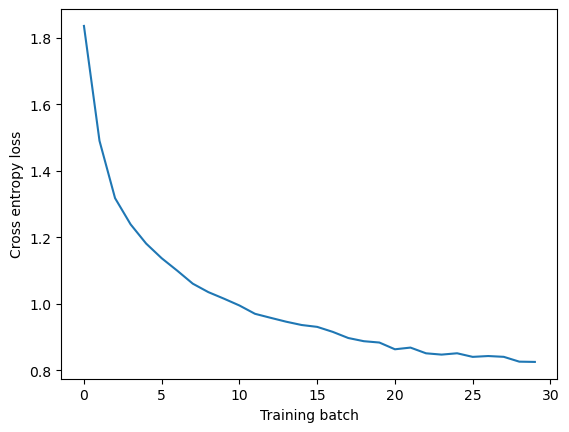

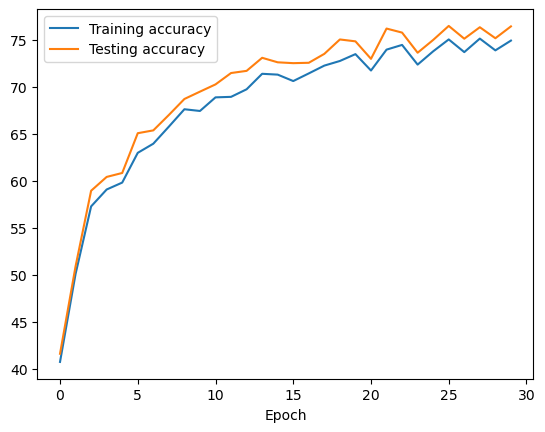

In [6]:
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters())
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

losses = [] # Stores the loss for each training batch
train_accs = [] # Stores the training accuracy after each epoch
test_accs = [] # Stores the testing accuracy after each epoch

num_epochs = 30
for epoch in range(num_epochs):
    total_loss=0
    correct_cnt=0
    
    print(f'\nEpoch {epoch + 1}/{num_epochs}.')
    start_time = time.perf_counter()
    
    model.train()
    
    for images, labels in train_iter:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        predict = model(images)
        l = criterion(predict, labels)
        l.backward()
        optimizer.step()
        total_loss += l.item() *images.shape[0]

    loss = round(total_loss / len(train_iter.dataset), 4)
    losses.append(loss)

    
    with torch.no_grad(): # Computing performance metrics does not require gradients
        model.eval()
        train_accs.append(evaluate_metric(model, train_iter, correct))
        test_accs.append(evaluate_metric(model, test_iter, correct)) #compute accuracy in the testing dataset

        end_time = time.perf_counter()
        print(f'Loss:{loss} Training accuracy: {train_accs[-1]:.2f}%. Testing accuracy: {test_accs[-1]:.2f}%. Duration: {end_time - start_time:.3f}s.') # Computes and displays training/testing dataset accuracy.



plt.plot(losses) # Plots the loss for each training batch
plt.xlabel('Training batch')
plt.ylabel('Cross entropy loss')
plt.show()


plt.plot(train_accs, label='Training accuracy')
plt.plot(test_accs, label='Testing accuracy')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.show()

# confusion matrix

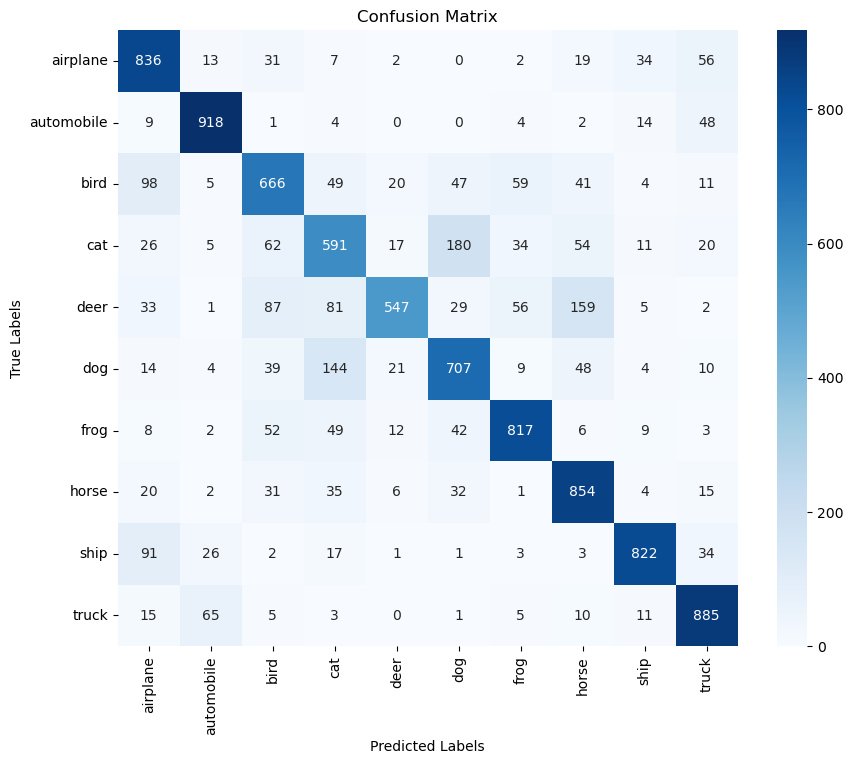

In [7]:
classes = train_dataset.classes
all_preds = []
all_labels = []

with torch.no_grad():
    model.eval()
    for images, labels in test_iter:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [8]:
def imshow(images, labels, predicted):
    fig, axs = plt.subplots(1, len(images), figsize=(15, 3))
    for i, (img, label, pred) in enumerate(zip(images, labels, predicted)):
        img = img / 2 + 0.5
        npimg = img.cpu().numpy()
        axs[i].imshow(np.transpose(npimg, (1, 2, 0)))
        axs[i].set_title(f'True: {classes[label]}\nPredicted: {classes[pred]}')
        axs[i].axis('off')
    plt.show()

correct_images, correct_labels, correct_predicted = [], [], []
incorrect_images, incorrect_labels, incorrect_predicted = [], [], []

with torch.no_grad():
    model.eval()
    for images, labels in test_iter:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        for img, label, pred in zip(images, labels, predicted):
            if pred == label and len(correct_images) < 5:
                correct_images.append(img)
                correct_labels.append(label.item())
                correct_predicted.append(pred.item())
            elif pred != label and len(incorrect_images) < 5:
                incorrect_images.append(img)
                incorrect_labels.append(label.item())
                incorrect_predicted.append(pred.item())
            if len(correct_images) >= 5 and len(incorrect_images) >= 5:
                break
        if len(correct_images) >= 5 and len(incorrect_images) >= 5:
            break


# Image examples of success cases

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Correctly Classified Images


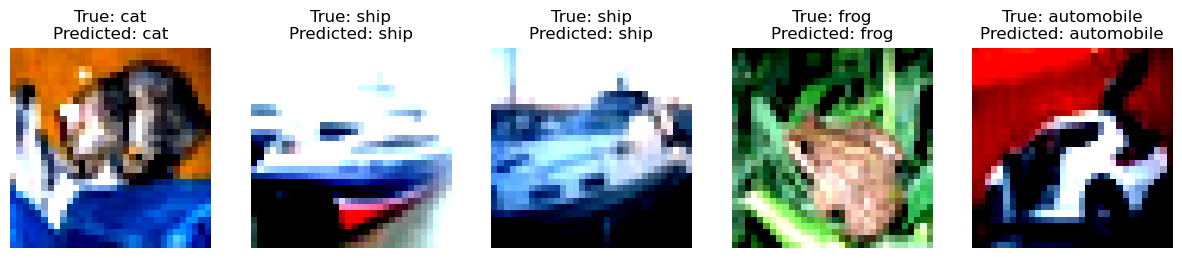

In [9]:
print('Correctly Classified Images')

if len(correct_images) >= 5:
    imshow(correct_images, correct_labels, correct_predicted)

# Image examples of failure cases

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Incorrectly Classified Images


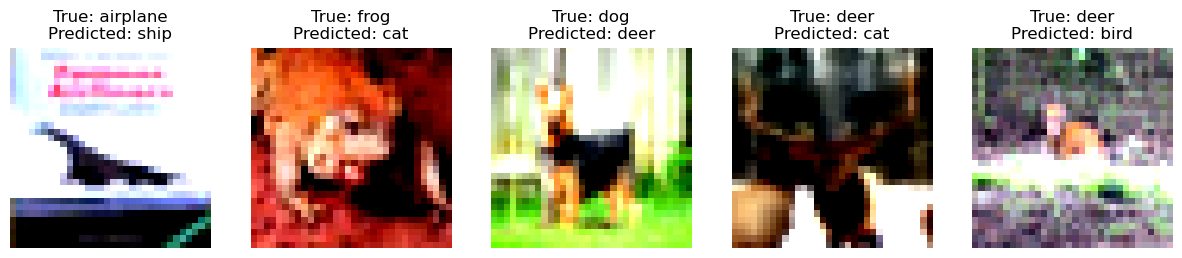

In [10]:
print("Incorrectly Classified Images")

if len(incorrect_images) >= 5:
    imshow(incorrect_images, incorrect_labels, incorrect_predicted)